# AlexNet

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torchsummary import summary
import torch.optim as optim
import time

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
root_dir = '../'
data_dir = root_dir + 'data/ADNI/'
train_dir = data_dir + 'train/'
test_dir = data_dir + 'test/'
BATCH_SIZE = 32
NUM_CLASS = 5

helper functions defined below


In [3]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


In [4]:
dataset = datasets.ImageFolder(train_dir, transform=transforms.Compose([transforms.Resize(256),
                                                                        transforms.CenterCrop(
                                                                            224),
                                                                        transforms.ToTensor()]))
loader = torch.utils.data.DataLoader(dataset,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=False)

mean = 0.
std = 0.
for images, _ in loader:
    # batch size (the last batch can have smaller size!)
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(loader.dataset)
std /= len(loader.dataset)
print('Mean of the training data channels:\n\t {}'.format(mean))
print('Std of the training data channels:\n\t {}'.format(std))


Mean of the training data channels:
	 tensor([0.2271, 0.2271, 0.2271])
Std of the training data channels:
	 tensor([0.2079, 0.2079, 0.2079])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

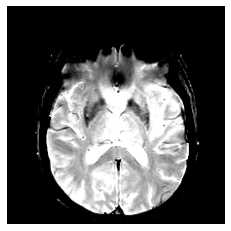

In [5]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

dataset = datasets.ImageFolder(train_dir, transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Looping through it, get a batch on each loop
for images, labels in dataloader:
    pass

# Get one batch
images, labels = next(iter(dataloader))
imshow(images[0], normalize=False)


In [6]:
train_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)])

test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean, std)])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)

test_data = datasets.ImageFolder(test_dir, transform=test_transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)


In [7]:
alexnet = models.alexnet(pretrained=True)
#alexnet.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4,4), padding=(2,2))
alexnet


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [8]:
# Freeze model params...
for param in alexnet.parameters():
    param.requires_grad = False


In [9]:
# change the final layer of the AlexNet model to match our class num for transfer learning
alexnet.classifier[6] = nn.Linear(4096,  NUM_CLASS)

# add softmax output layer
# alexnet.classifier.add_module('7', nn.LogSoftmax(dim=1))
summary(alexnet, (3, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 6, 6]           --
|    └─Conv2d: 2-1                       [-1, 64, 55, 55]          (23,296)
|    └─ReLU: 2-2                         [-1, 64, 55, 55]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 27, 27]          --
|    └─Conv2d: 2-4                       [-1, 192, 27, 27]         (307,392)
|    └─ReLU: 2-5                         [-1, 192, 27, 27]         --
|    └─MaxPool2d: 2-6                    [-1, 192, 13, 13]         --
|    └─Conv2d: 2-7                       [-1, 384, 13, 13]         (663,936)
|    └─ReLU: 2-8                         [-1, 384, 13, 13]         --
|    └─Conv2d: 2-9                       [-1, 256, 13, 13]         (884,992)
|    └─ReLU: 2-10                        [-1, 256, 13, 13]         --
|    └─Conv2d: 2-11                      [-1, 256, 13, 13]         (590,080)
|    └─ReLU: 2-12                        [-1, 256, 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 6, 6]           --
|    └─Conv2d: 2-1                       [-1, 64, 55, 55]          (23,296)
|    └─ReLU: 2-2                         [-1, 64, 55, 55]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 27, 27]          --
|    └─Conv2d: 2-4                       [-1, 192, 27, 27]         (307,392)
|    └─ReLU: 2-5                         [-1, 192, 27, 27]         --
|    └─MaxPool2d: 2-6                    [-1, 192, 13, 13]         --
|    └─Conv2d: 2-7                       [-1, 384, 13, 13]         (663,936)
|    └─ReLU: 2-8                         [-1, 384, 13, 13]         --
|    └─Conv2d: 2-9                       [-1, 256, 13, 13]         (884,992)
|    └─ReLU: 2-10                        [-1, 256, 13, 13]         --
|    └─Conv2d: 2-11                      [-1, 256, 13, 13]         (590,080)
|    └─ReLU: 2-12                        [-1, 256, 

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(alexnet.classifier.parameters(), lr=0.001)


for ii, (inputs, labels) in enumerate(trainloader):

    start = time.time()

    outputs = alexnet.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    if ii == 3:
        break

print(
    f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")


Device = cpu; Time per batch: 0.252 seconds


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(alexnet.classifier.parameters(), lr=0.001)
epochs = 1
steps = 0

train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0

    for images, labels in trainloader:
        steps += 1
        optimizer.zero_grad()
        logits = alexnet(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_losses.append(running_loss)

        if steps % 5 == 0:
            test_loss, accuracy = 0, 0
            with torch.no_grad():
                alexnet.eval()

                for images, labels, in testloader:
                    logits = alexnet(images)
                    test_loss += criterion(logits, labels)

                    ps = torch.exp(logits)

                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)

                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Epoch: {e+1}/{epochs}| "
                  f"Train_loss: {running_loss}| "
                  f"Test_loss: {test_loss/len(testloader)}| "
                  f"Accuracy: {accuracy/len(testloader)}")
            alexnet.train()
            running_loss = 0

Epoch: 1/1| Train_loss: -33.861852169036865| Test_loss: -1.5736287832260132| Accuracy: 0.11607142857142858
Epoch: 1/1| Train_loss: -15.073699831962585| Test_loss: -3.7097439765930176| Accuracy: 0.11607142857142858
Epoch: 1/1| Train_loss: -43.666436195373535| Test_loss: -6.008261203765869| Accuracy: 0.11607142857142858
Epoch: 1/1| Train_loss: -69.51523780822754| Test_loss: -8.377192497253418| Accuracy: 0.25
Epoch: 1/1| Train_loss: -10.719750195741653| Test_loss: -10.797463417053223| Accuracy: 0.38839285714285715
Epoch: 1/1| Train_loss: -8.584130257368088| Test_loss: -13.25084400177002| Accuracy: 0.38839285714285715
Epoch: 1/1| Train_loss: -23.17707049846649| Test_loss: -16.269542694091797| Accuracy: 0.38839285714285715
